In [1]:
using Random, JuMP, Clp, LinearAlgebra, SparseArrays, DifferentialEquations, Plots, Sundials, LaTeXStrings 
Random.seed!(1)

n = 5
m = 2
c = 2.0*rand(n)
A = 2.0*rand(m,n) .- 1.0
b = 2.0*rand(m) .- 1.0
# using CLP to solve the LP: min x' * c, s.t. Ax>=b, x>=0
Prob = Model(Clp.Optimizer)
@variable(Prob, x[1:n]>=0)
@objective(Prob, Min, c'*x)
@constraint(Prob, A*x .>= b)
optimize!(Prob)
status = termination_status(Prob)
println("Solver status: ", status)
x_opt = [value(x[i]) for i in 1:n]

Solver status: OPTIMAL
Coin0506I Presolve 2 (0) rows, 3 (-2) columns and 6 (-4) elements
Clp0006I 0  Obj 0.48418382 Primal inf 1.0498262 (2)
Clp0006I 2  Obj 0.89566991
Clp0000I Optimal - objective value 0.89566991
Coin0511I After Postsolve, objective 0.89566991, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.8956699051 - 2 iterations time 0.002, Presolve 0.00


5-element Vector{Float64}:
 0.21039157399408798
 1.2381097397489849
 0.0
 0.0
 0.0

In [2]:
function Homogeneous_massfun(z,c,A,b,n,m)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    nabla_psi = [zeros(n,n) -A' c;
                 A zeros(m,m) -b;
                 -c' b' 0]
    M = [nabla_psi -Diagonal(ones(n+m+1));
         Diagonal([s;v;kappa]) Diagonal([x;y;tau])]
    return M
end

function Homogeneous_odefun(z,c,A,b,n,m,k)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    temp = [-A'*y+tau*c-s;
            A*x-tau*b-v;
            -x'*c+y'*b-kappa;
            x.*s;
            y.*v;
            tau*kappa]
    dzdt = -k*(1/norm(temp)+norm(temp))*temp
    return dzdt
end

function Homogeneous_ode!(residual, dz, z, p, t)
    c, A, b, n, m, k = p
    residual .= Homogeneous_massfun(z,c,A,b,n,m) * dz - Homogeneous_odefun(z,c,A,b,n,m,k)
end

Homogeneous_ode! (generic function with 1 method)

In [3]:
Tp = [1.0,0.8,0.6,0.4,0.2,0.1]

k_1 = 2*pi/(4.0*Tp[1])
k_2 = 2*pi/(4.0*Tp[2])
k_3 = 2*pi/(4.0*Tp[3])
k_4 = 2*pi/(4.0*Tp[4])
k_5 = 2*pi/(4.0*Tp[5])
k_6 = 2*pi/(4.0*Tp[6])

Tmax_1 = 0.999*Tp[1]
Tmax_2 = 0.9999*Tp[2]
Tmax_3 = 0.9999*Tp[3]
Tmax_4 = 0.9999*Tp[4]
Tmax_5 = 0.9999*Tp[5]
Tmax_6 = 0.9999*Tp[6]

p_1 = (c,A,b,n,m,k_1)
p_2 = (c,A,b,n,m,k_2)
p_3 = (c,A,b,n,m,k_3)
p_4 = (c,A,b,n,m,k_4)
p_5 = (c,A,b,n,m,k_5)
p_6 = (c,A,b,n,m,k_6)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_1)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_1, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_1 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_1 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_2)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_2, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_2 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]) 
sol_2 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_3)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_3, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_3 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]) 
sol_3 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_4)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_4, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_4 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]) 
sol_4 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_5)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_5, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_5 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]) 
sol_5 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_6)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_6, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_6 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]); 
sol_6 = solve(Homogeneous_prob,DFBDF(),saveat=t_points);

┌ Warning: At t=0.9916288297557966, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.019059872670428104. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.7932896071715061, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.0771101957036782. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.5948815299263103, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.03536163556947011. Aborting. There is either 

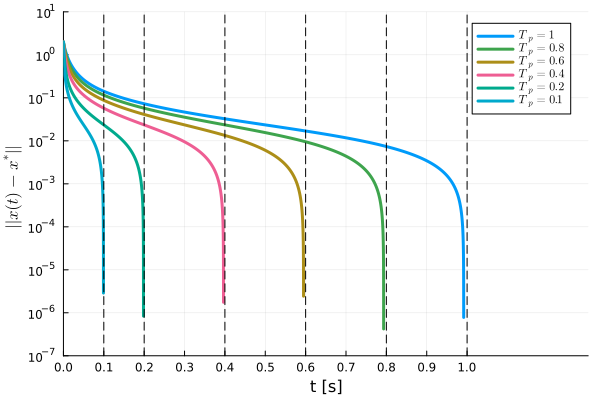

In [4]:
tau_equi_1= sol_1[n+m+1,end]
x_traj_1 = 1/tau_equi_1 .* sol_1[1:n,:]
rel_err_1 = zeros(size(x_traj_1, 2))
for i in 1:size(x_traj_1, 2)
    rel_err_1[i] = norm(x_traj_1[:, i] - x_opt)
end

tau_equi_2 = sol_2[n+m+1,end]
x_traj_2 = 1/tau_equi_2 .* sol_2[1:n,:]
rel_err_2 = zeros(size(x_traj_2, 2))
log_rel_err_2 = zeros(size(x_traj_2, 2))
for i in 1:size(x_traj_2, 2)
    rel_err_2[i] = norm(x_traj_2[:, i] - x_opt)
end

tau_equi_3 = sol_3[n+m+1,end]
x_traj_3 = 1/tau_equi_3 .* sol_3[1:n,:]
rel_err_3 = zeros(size(x_traj_3, 2))
for i in 1:size(x_traj_3, 2)
    rel_err_3[i] = norm(x_traj_3[:, i] - x_opt)
end

tau_equi_4 = sol_4[n+m+1,end]
x_traj_4 = 1/tau_equi_4 .* sol_4[1:n,:]
rel_err_4 = zeros(size(x_traj_4, 2))
for i in 1:size(x_traj_4, 2)
    rel_err_4[i] = norm(x_traj_4[:, i] - x_opt)
end

tau_equi_5 = sol_5[n+m+1,end]
x_traj_5 = 1/tau_equi_5 .* sol_5[1:n,:]
rel_err_5 = zeros(size(x_traj_5, 2))
for i in 1:size(x_traj_5, 2)
    rel_err_5[i] = norm(x_traj_5[:, i] - x_opt)
end

tau_equi_6 = sol_6[n+m+1,end]
x_traj_6 = 1/tau_equi_6 .* sol_6[1:n,:]
rel_err_6 = zeros(size(x_traj_6, 2))
for i in 1:size(x_traj_6, 2)
    rel_err_6[i] = norm(x_traj_6[:, i] - x_opt)
end

plot(sol_1.t, rel_err_1, linewidth=3, yscale=:log10, label=L"$T_p=1$", yticks=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1], xticks=0:0.1:1, xlabel="t [s]", ylabel=L"$\|\|x(t) - x^{*}\|\|$")
vline!([Tp[1]], linestyle=:dash, color=:black, label="")
xlims!(0, 1.3)
ylims!(1e-7,1e1)
plot!(sol_2.t, rel_err_2, linewidth=3, label=L"$T_p=0.8$")
vline!([Tp[2]], linestyle=:dash, color=:black, label="")
plot!(sol_3.t, rel_err_3, linewidth=3, label=L"$T_p=0.6$")
vline!([Tp[3]], linestyle=:dash, color=:black, label="")
plot!(sol_4.t, rel_err_4, linewidth=3, label=L"$T_p=0.4$")
vline!([Tp[4]], linestyle=:dash, color=:black, label="")
plot!(sol_5.t, rel_err_5, linewidth=3,label=L"$T_p=0.2$")
vline!([Tp[5]], linestyle=:dash, color=:black, label="")
plot!(sol_6.t, rel_err_6, linewidth=3, label=L"$T_p=0.1$")
vline!([Tp[6]], linestyle=:dash, color=:black, label="")



In [5]:
savefig("Fig1_LP.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig1_LP.pdf"

In [6]:
Tp = 1.0
k = 2*pi/(4.0*Tp)
Tmax = 0.9999*Tp
p = (c,A,b,n,m,k)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_1 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_1 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 10*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_2 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_2 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 20*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_3 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_3 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 40*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_4 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_4 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 60*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_5 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol_5 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 80*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_6 = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff]);
sol_6 = solve(Homogeneous_prob,DFBDF(),saveat=t_points);

┌ Warning: At t=0.9916288107354049, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.014206819592692646. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.9976648119929789, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.008394187125164347. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.9992792272945954, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.22301100838864021. Aborting. There is eithe

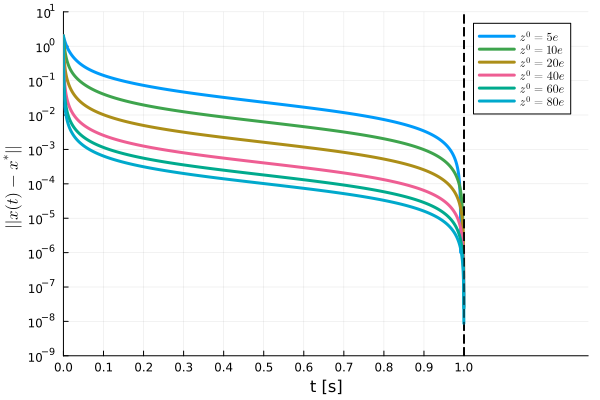

In [7]:
tau_equi_1= sol_1[n+m+1,end]
x_traj_1 = 1/tau_equi_1 .* sol_1[1:n,:]
rel_err_1 = zeros(size(x_traj_1, 2))
for i in 1:size(x_traj_1, 2)
    rel_err_1[i] = norm(x_traj_1[:, i] - x_opt)
end

tau_equi_2 = sol_2[n+m+1,end]
x_traj_2 = 1/tau_equi_2 .* sol_2[1:n,:]
rel_err_2 = zeros(size(x_traj_2, 2))
log_rel_err_2 = zeros(size(x_traj_2, 2))
for i in 1:size(x_traj_2, 2)
    rel_err_2[i] = norm(x_traj_2[:, i] - x_opt)
end

tau_equi_3 = sol_3[n+m+1,end]
x_traj_3 = 1/tau_equi_3 .* sol_3[1:n,:]
rel_err_3 = zeros(size(x_traj_3, 2))
for i in 1:size(x_traj_3, 2)
    rel_err_3[i] = norm(x_traj_3[:, i] - x_opt)
end

tau_equi_4 = sol_4[n+m+1,end]
x_traj_4 = 1/tau_equi_4 .* sol_4[1:n,:]
rel_err_4 = zeros(size(x_traj_4, 2))
for i in 1:size(x_traj_4, 2)
    rel_err_4[i] = norm(x_traj_4[:, i] - x_opt)
end

tau_equi_5 = sol_5[n+m+1,end]
x_traj_5 = 1/tau_equi_5 .* sol_5[1:n,:]
rel_err_5 = zeros(size(x_traj_5, 2))
for i in 1:size(x_traj_5, 2)
    rel_err_5[i] = norm(x_traj_5[:, i] - x_opt)
end

tau_equi_6 = sol_6[n+m+1,end]
x_traj_6 = 1/tau_equi_6 .* sol_6[1:n,:]
rel_err_6 = zeros(size(x_traj_6, 2))
for i in 1:size(x_traj_6, 2)
    rel_err_6[i] = norm(x_traj_6[:, i] - x_opt)
end
plot(sol_1.t, rel_err_1, label=L"$z^0=5e$", linewidth=3, yscale=:log10, yticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1],xticks=0:0.1:1, xlabel="t [s]", ylabel=L"$\|\|x(t) - x^{*}\|\|$", legend=:topright)
vline!([Tp], linestyle=:dash, color=:black, label="")
xlims!(0, 1.31)
ylims!(1e-9,1e1)
plot!(sol_2.t, rel_err_2, label=L"$z^0=10e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_3.t, rel_err_3, label=L"$z^0=20e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_4.t, rel_err_4, label=L"$z^0=40e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_5.t, rel_err_5, label=L"$z^0=60e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_6.t, rel_err_6, label=L"$z^0=80e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")


In [8]:
savefig("Fig2_LP.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig2_LP.pdf"